_Version log: Branch of V12. Trying to find a better (more sparse) basis. scipy signal functions_

In [150]:
import sys
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy.ndimage as spimg
from scipy import optimize as spopt, fft as spfft, signal as spsig
from PIL import Image #I prefer Pillow to imageio
from tqdm import tqdm
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping/measurement matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether, the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the transformation matrix $M$ and $\mathcal{F} (Y) = Z$ as,
\begin{equation}
    ||M \times Z - X||_{2} + \alpha ||Z||_{1}.
\end{equation}

In [151]:
def open_compressed_dataset(file_name, file_type, compression):
    if file_type == ".csv":
        img = np.loadtxt("data\\" +file_name +file_type, delimiter=",")
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    elif file_type == "":
        img = np.fromfile("data\\" +file_name +file_type, dtype= np.float32)
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, img

def subsample_1d(array, subsampling_percentage = 0.5, subsampling_method = "random"):
    
    total_points = len(array)

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Not nessisary but makes it easier to look at.
    signal = np.full(total_points, np.nan)
    signal[subsampled_points] = array[subsampled_points]
    signal_sparce = array[subsampled_points]

    return signal, signal_sparce, subsampled_points



def Coeffients2Amplitudes(FT, freqs): #stolen from interferogram code
    samples = len(FT)
    num_of_freqs = len(FT)//2 +1
    amplitude = np.zeros(num_of_freqs)
    amplitude[0] = np.abs(FT[0])
    if (samples//2 == samples/2): #if even
        amplitude[-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                            np.abs( FT[:num_of_freqs-1:-1] ))

        freqs = freqs[:num_of_freqs]
        freqs[-1] = -freqs[-1] #The niquist freqency is considered to be negative by np.fft.fftfreq(). This should make it positive.
        wavelengths = 1/freqs
    else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))
        
        freqs = freqs[:num_of_freqs]
        wavelengths = 1/freqs
    return amplitude, wavelengths, freqs

def spectralFFT(interferogram1D, theta= np.pi/6, pixel_pitch= 1): #stolen from interferogram code

    FT = np.fft.fft(interferogram1D, norm = "forward")
    freqs = np.fft.fftfreq(len(FT), pixel_pitch)
    amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

    corrected_wavelengths = wavelengths *2*np.sin(theta)
    corrected_frequencys = 1/corrected_wavelengths
    
    amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise

    return amplitude, corrected_wavelengths, corrected_frequencys


def basis_function(x): #IDK
    return spfft.dct(x)

def inverse_basis_function(freqs):
    N = len(freqs)
    x = np.arange(N)
    x = x -np.mean(x)
    amps = np.zeros(N)
    normalisation_factor = 2*np.pi/N

    for n, amp in enumerate(freqs):
        amps += amp *spsig.gausspulse(x, n/2 *normalisation_factor)

    return amps


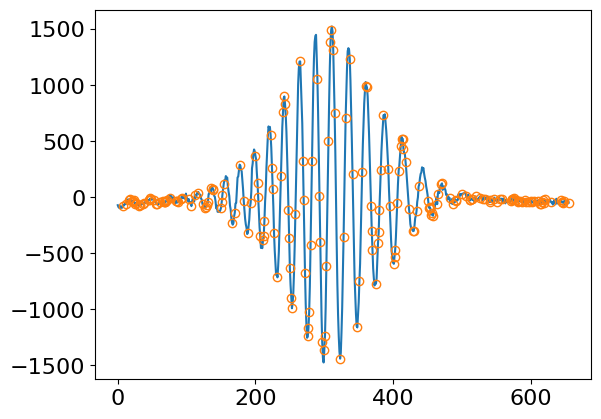

In [152]:
file_name = "ir2_processed"
file_type = ""
compression = 1 #fraction of the dataset to keep
subsample_percentage = 0.3 #fraction of the dataset to subsample
subsampling_method= "random" #"random" "regular"

# original image
target, img = open_compressed_dataset(file_name, file_type, compression)
#target = target[30:70] #crop it
total_points = len(target)

signal, signal_sparce, random_points = subsample_1d(target, subsampling_percentage= subsample_percentage, subsampling_method= subsampling_method)


plt.plot(target)
plt.plot(signal, marker= "o", markerfacecolor= "None", linestyle= "None")

plt.show()

In [153]:
target.shape

(656,)

In [154]:
frequency_vector = np.zeros((6, 6))
frequency_vector[0,0] = 1.

print(*frequency_vector.T)

[1. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.]


In [155]:
reduced_points = len(random_points)
null_vector = np.zeros(total_points)

measurement_matrix = np.identity(total_points, dtype= np.float16)
measurement_matrix = measurement_matrix[random_points] #measurement matrix operator

transformation_matrix = np.zeros([reduced_points, total_points], dtype= np.float64) #scikit uses np.float64
for n in tqdm(range(total_points)):
    frequency_vector = np.zeros(total_points) #frequency_vector is a slice of the identerty matrix. It represents one frequency.
    frequency_vector[n] = 1.
    frequency_vector = inverse_basis_function(frequency_vector)
    transformation_matrix[:, n] = frequency_vector[random_points]

100%|██████████| 656/656 [00:24<00:00, 26.91it/s]


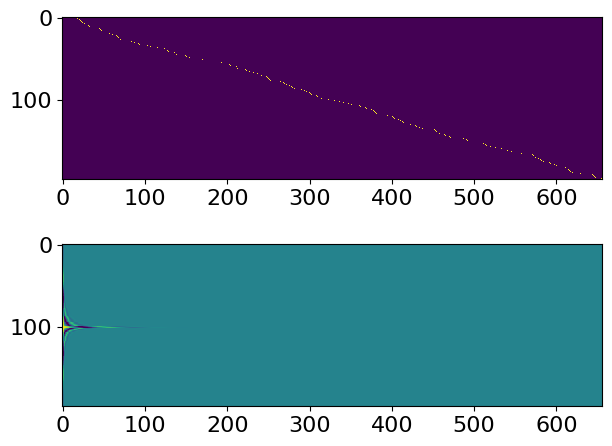

In [156]:
fig, axs = plt.subplots(2,1)

axs[0].imshow(measurement_matrix, interpolation= "nearest")
axs[1].imshow(transformation_matrix, interpolation= "nearest")

plt.tight_layout()
plt.show()

In [159]:
regularization_coeffient = 1e-7 #DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

lasso = Lasso(alpha=regularization_coeffient)
lasso.fit(transformation_matrix, signal_sparce)
result_DCT = lasso.coef_

print(result_DCT.shape)
print(total_points)

(656,)
656


C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.299e+06, tolerance: 3.827e+03
  model = cd_fast.enet_coordinate_descent(


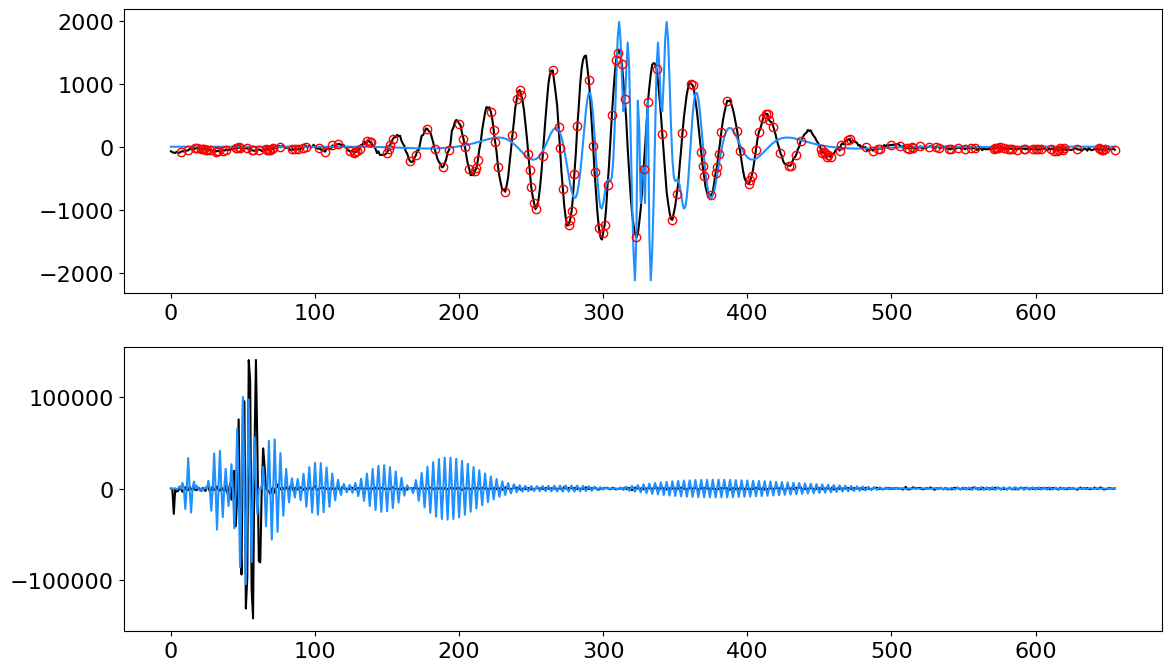

In [160]:
result = inverse_basis_function(result_DCT)
result_DCT = spfft.dct(result)
target_DCT = spfft.dct(target)

plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(2,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(result, color= "dodgerblue", label= "reconstructed signal")
axs[0].plot(signal, marker= "o", markerfacecolor= "None", color= "red", linestyle= "None", label= "known samples")
axs[1].plot(target_DCT, color= "k", label= "actual FFT")
axs[1].plot(result_DCT, color= "dodgerblue", label= "reconstructed FFT (from samples)")

plt.tight_layout()
plt.show()